# <span style ='color:orange'>Imports

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import shap

%reload_ext autoreload
%autoreload 2

from data_boxscore.data import load_dataframes, custom_query_df
from data_boxscore.xai import shap_query
from data_boxscore.constants import  features_minmax, features_no_scaling, features_perc, features_robust, features_standard

# <span style ='color:blue'>Loading data

In [ ]:
#df = pd.read_csv('./raw_data/data.csv', index_col = 0)
#df

,game_id,home_team,away_team,diff_score,league,season,phase,league_id,gameday,season_half,...,away_pourc_penal_off,away_pourc_penal_def,away_pourc_penal_hors_jeu,away_nb_carton_jaune,away_nb_carton_rouge,away_tps_poss_22_adv,away_tps_poss_22,away_nb_rucks_3_,home_win,split
0,0,Zebre,Sigma Lions,-12,UNITEDCHAMPIONSHIP,2021_2022,Season,1,1,2021_2022_1,...,44,56,11,1,0,98,191,4,0,0
1,1,Ulster,Glasgow,6,UNITEDCHAMPIONSHIP,2021_2022,Season,1,1,2021_2022_1,...,36,64,0,1,0,639,199,57,1,0
2,2,Cardiff,Connacht,12,UNITEDCHAMPIONSHIP,2021_2022,Season,1,1,2021_2022_1,...,11,89,0,2,0,41,176,7,1,0
3,3,Benetton Rugby Trevise,DHL Stormers,3,UNITEDCHAMPIONSHIP,2021_2022,Season,1,1,2021_2022_1,...,30,70,10,0,0,31,108,8,1,0
4,4,Edimbourg,Scarlets,4,UNITEDCHAMPIONSHIP,2021_2022,Season,1,1,2021_2022_1,...,75,25,50,0,0,361,176,18,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,2302,Bath rugby,Northampton Saints,31,PREMIERSHIP,2023_2024,Season,15,18,2023_2024_2,...,67,33,0,0,0,317,59,28,1,3
2054,2303,Gloucester rugby,Newcastle Falcons,40,PREMIERSHIP,2023_2024,Season,15,18,2023_2024_2,...,44,56,11,1,0,360,91,27,1,3
2055,2304,Harlequins,Bristol Bears,-25,PREMIERSHIP,2023_2024,Season,15,18,2023_2024_2,...,67,33,11,0,0,265,94,52,0,3
2056,2305,Leicester Tigers,Exeter Chiefs,18,PREMIERSHIP,2023_2024,Season,15,18,2023_2024_2,...,10,90,20,3,0,235,226,75,1,3


In [12]:
team = 'Stade Toulousain'
league = 'TOP14'
season = '2023_2024'

excluded_columns = ['diff_score', 'league_id','gameday', 'game_id']

In [13]:
gdf, X_train, y_train, X_val, y_val, X_test, y_test, X_query, y_query = load_dataframes(filename='data.csv',
                                                                    features_standard = features_standard, 
                                                                    features_minmax = features_minmax, 
                                                                    features_robust = features_robust, 
                                                                    features_perc = features_perc,
                                                                    features_no_scaling = features_no_scaling,              
                                                                    use_ELO = True,
                                                                    k_elo = 20,
                                                                    excluded_columns=excluded_columns,
                                                                    team=team,
                                                                    season=season,
                                                                    league=league)
print(gdf.shape, X_train.shape, X_val.shape ,X_test.shape, )
gdf['home_win'].mean()

(2058, 169) (1042, 157) (328, 157) (328, 157)


0.6963070942662779

In [14]:
gdf.head(5)

,game_id,home_team,away_team,diff_score,league,season,phase,league_id,gameday,season_half,...,away_pourc_penal_def,away_pourc_penal_hors_jeu,away_nb_carton_jaune,away_nb_carton_rouge,away_tps_poss_22_adv,away_tps_poss_22,away_nb_rucks_3_,home_win,split,ELO_diff_before
0,0,Zebre,Sigma Lions,-12,UNITEDCHAMPIONSHIP,2021_2022,Season,1,1,2021_2022_1,...,56,11,1,0,98,191,4,0,0,0.0
1,1,Ulster,Glasgow,6,UNITEDCHAMPIONSHIP,2021_2022,Season,1,1,2021_2022_1,...,64,0,1,0,639,199,57,1,0,0.0
2,2,Cardiff,Connacht,12,UNITEDCHAMPIONSHIP,2021_2022,Season,1,1,2021_2022_1,...,89,0,2,0,41,176,7,1,0,0.0
3,3,Benetton Rugby Trevise,DHL Stormers,3,UNITEDCHAMPIONSHIP,2021_2022,Season,1,1,2021_2022_1,...,70,10,0,0,31,108,8,1,0,0.0
4,4,Edimbourg,Scarlets,4,UNITEDCHAMPIONSHIP,2021_2022,Season,1,1,2021_2022_1,...,25,50,0,0,361,176,18,1,0,0.0


In [17]:
X_test = X_test[:10]
y_test = y_test[:10]
X_test.shape, y_test.shape

((10, 157), (10,))

# <span style ='color:green'>Models

In [18]:
from sklearn.svm import SVC

model = SVC(kernel = 'rbf', probability=True, C = 50, gamma = 0.0005)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Model accuracy = {accuracy_score(y_pred, y_test)}")

Model accuracy = 0.8


# <span style ='color:lightgreen'>XAI

### Local

In [21]:
# creating SV object with all X_train in the background
shap_prob_explainer = shap.Explainer(model.predict_proba, X_train)
# Fitting on X_test
sv_prob = shap_prob_explainer(X_test)

PermutationExplainer explainer: 11it [00:17,  3.43s/it]                        


Index max in test set : 10


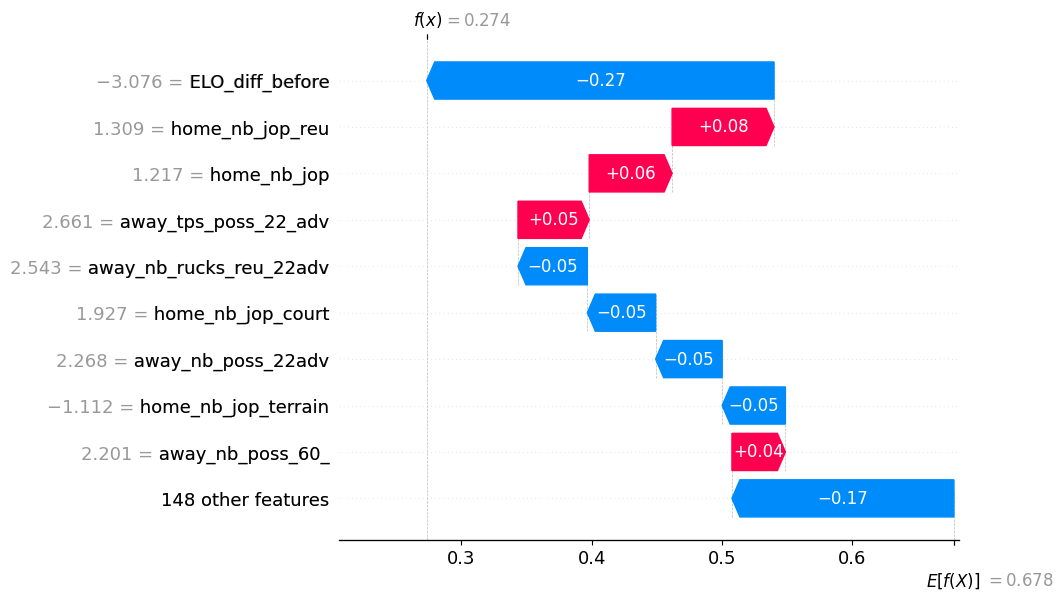

In [22]:
ind = 9

print(f"Index max in test set : {X_test.shape[0]}")
shap.plots.waterfall(sv_prob[ind,:,1])

### Global

In [101]:
# creating SV object with all X_train in the background
shap_pred_explainer = shap.Explainer(model.predict, X_train)
# Fitting on X_test
sv_pred = shap_pred_explainer(X_test)

PermutationExplainer explainer: 11it [00:15,  3.93s/it]                        


<Axes: xlabel='SHAP value (impact on model output)'>

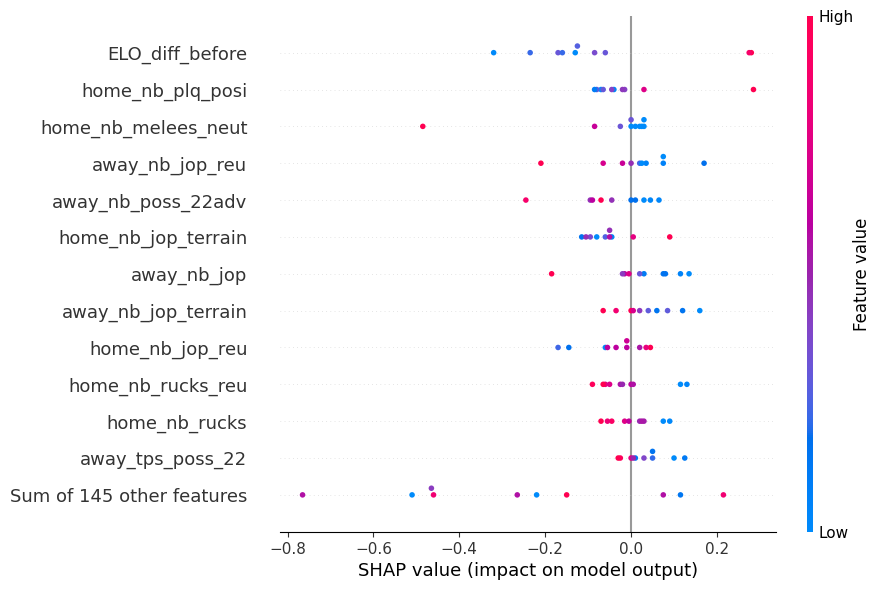

In [102]:
shap.plots.beeswarm(sv_pred, max_display=13, show=False)

### Query

In [24]:
X_query.shape

(26, 157)

In [25]:
shap_query_df = shap_query(df =gdf,
                           X_query = X_query,
                           shap_explainer= shap_prob_explainer,
                           team=team,
                           season = season,
                           league = league)
shap_query_df.head()

PermutationExplainer explainer: 27it [00:42,  2.14s/it]                        

(26, 169) (26, 157) RangeIndex(start=0, stop=26, step=1) RangeIndex(start=0, stop=26, step=1)


,game_id,home_team,away_team,team_tps_poss,team_pourc_poss,team_nb_poss,team_nb_poss_0_30,team_nb_poss_30_60,team_nb_poss_60_,team_pourc_poss_22adv,...,opponent_nb_penal,opponent_pourc_penal_off,opponent_pourc_penal_def,opponent_pourc_penal_hors_jeu,opponent_nb_carton_jaune,opponent_nb_carton_rouge,opponent_tps_poss_22_adv,opponent_tps_poss_22,opponent_nb_rucks_3_,ELO_diff_before
0,801,Aviron Bayonnais,Stade Toulousain,-0.002510,0.007102,-0.037405,-0.029769,0.002121,0.012891,-0.001104,...,-0.004107,-0.010929,-0.012195,0.000413,-0.009354,-0.002183,0.003139,0.000348,0.000947,-0.036027
1,804,Stade Toulousain,Montpellier Herault Rugby,-0.008494,-0.007457,0.008028,0.000915,-0.003363,0.004621,-0.000248,...,0.008406,0.002287,0.000953,0.006370,-0.009391,0.044646,0.021373,0.010083,-0.003699,0.044065
2,815,Oyonnax Rugby,Stade Toulousain,-0.013259,-0.006671,0.044731,0.027516,0.001008,0.015874,0.004464,...,0.001419,0.001390,0.001303,0.002330,-0.009395,-0.004121,-0.003955,-0.001138,-0.005419,-0.066547
3,816,Stade Toulousain,Union Bordeaux Begles,0.012443,0.031970,0.021504,0.021136,-0.006263,-0.005395,0.002710,...,0.010135,0.001136,-0.003161,0.001949,-0.009249,-0.002034,-0.006203,0.019266,0.001702,0.048628
4,829,Section Paloise,Stade Toulousain,-0.001135,0.004922,-0.014287,-0.016706,0.002764,0.002272,0.009145,...,0.004596,-0.000868,-0.000863,0.002201,-0.011317,-0.004508,-0.000257,0.001304,0.005729,-0.087652


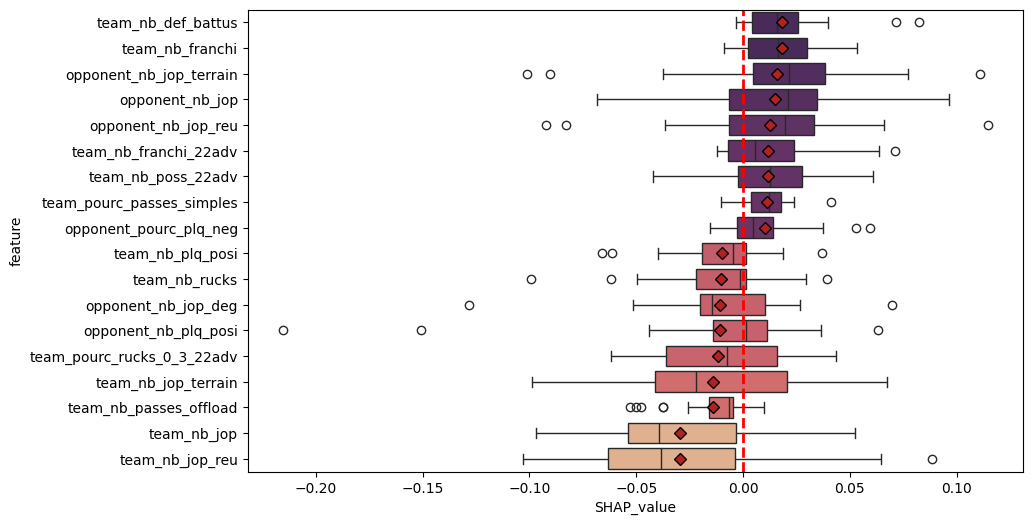

In [29]:
threshold = 0.01

fig, ax = plt.subplots(1,1,figsize = (10,6))
team_expl_cols = shap_query_df.drop(columns = ['game_id','home_team','away_team']).columns
id = pd.MultiIndex.from_product([shap_query_df[team_expl_cols].index, shap_query_df[team_expl_cols].columns], names=('gameday', 'feature'))
t_df = pd.DataFrame(np.array(shap_query_df[team_expl_cols]).reshape(len(shap_query_df[team_expl_cols])*len(shap_query_df[team_expl_cols].columns),1), index = id).rename(columns={0:'SHAP_value'})
t_df.reset_index(inplace= True)
feat_mask = (t_df.groupby('feature').mean()['SHAP_value'].abs() > threshold).rename('Threshold_filter')
mean_shap = t_df.groupby('feature').mean()['SHAP_value'].rename('Mean_SHAP_value')
t_df = t_df.merge(feat_mask, left_on = 'feature', right_index = True)
t_df = t_df.merge(mean_shap, left_on = 'feature', right_index = True)
t_df.sort_values(by = 'Mean_SHAP_value', ascending = False, inplace=True)
meanpointprops = dict(marker='D', markeredgecolor='black',
                    markerfacecolor='firebrick')
sns.boxplot(data = t_df[t_df['Threshold_filter']], x = 'SHAP_value', y = 'feature', hue = 'Mean_SHAP_value', palette = 'flare', legend = False, ax=ax, showmeans = True, meanprops = meanpointprops)
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=2)
plt.show()
plt.close()